# DIN

阿里妈妈在CTR预估领域有3篇比较有名的文章。

2017年的深度兴趣网络, DIN(DeepInterestNetwork)。 

2018年的深度兴趣演化网络, DIEN(DeepInterestEvolutionNetWork)。

2019年的深度会话兴趣网络, DSIN(DeepSessionInterestNetWork)。

这3篇文章的主要思想和相互关系用一句话分别概括如下：

第1篇DIN说，用户的行为日志中只有一部分和当前候选广告有关。可以利用Attention机制从用户行为日志中建模出和当前候选广告相关的用户兴趣表示。我们试过涨点了嘻嘻嘻。

第2篇DIEN说，用户最近的行为可能比较远的行为更加重要。可以用循环神经网络GRU建模用户兴趣随时间的演化。我们试过也涨点了嘿嘿嘿。

第3篇DSIN说，用户在同一次会话中的行为高度相关，在不同会话间的行为则相对独立。可以把用户行为日志按照时间间隔分割成会话并用SelfAttention机制建模它们之间的相互作用。我们试过又涨点了哈哈哈。


参考材料：

* DIN论文： https://arxiv.org/pdf/1706.06978.pdf

* 推荐系统中的注意力机制： https://zhuanlan.zhihu.com/p/51623339

* 阿里经典兴趣网络： https://zhuanlan.zhihu.com/p/429433768

* 从DIN到DIEN看阿里CTR算法的进化脉络： https://zhuanlan.zhihu.com/p/78365283

* DIN+DIEN，机器学习唯一指定涨点技Attention： https://zhuanlan.zhihu.com/p/431131396

* Attention机制简单总结： https://zhuanlan.zhihu.com/p/46313756

* 代码实现参考： https://github.com/GitHub-HongweiZhang/prediction-flow


本篇文章我们主要介绍DIN，下一篇文章我们介绍DIEN。 



## 〇，Attention原理概述

众所周知，Attention机制在深度学习领域是非常通用的涨分技巧。其主要作用是提升模型的自适应能力。

Attention机制的一些常用功能和典型范例总结如下：

* 1,动态特征选择，根据样本不同动态地赋予特征以不同的权重，典型范例如SENet中的SEAttention，DIN中的Attention.

* 2,动态特征交互，动态地构建特征之间的交互强弱关系，提取高阶特征。典型范例如Transformer中的的Attention。

* 3,动态模块集成，类似多模型融合集成，但是不同子模块的权重是动态的。典型范例如MOE中的门控注意力机制。


在许多Attention机制的应用场景中，输入分成Query(Q)和Key(K)。Query是当前关注项的Embedding向量，Key是待和当前关注项进行匹配的Embedding向量。

例如在广告CTR领域，Query就是当前待预估的广告，Key就是用户历史上点击过的广告，通过Attention机制建立当前待预估的广告和用户历史上点击过的广告的相关性强弱。

又比如在NLP翻译领域，Query就是当前正在解码的译文单词词向量，Key就是原文单词序列的词向量，通过Attention机制可以建立译文单词和原文单词的对应关系。


Attention机制的核心实现是计算注意力权重，一些的常用实现形式如下：

$$attention = f(Q,K)$$


* 1,多层感知机方法

先将Query和Key进行拼接，然后接一个多层感知机。

这种方法不需要Query和Key的向量长度相等，Query和Key之间的交互方式是通过学习获得的。

$$f(Q,K) = mlp([Q;K])$$


* 2,Bilinear方法

通过一个权重矩阵直接建立Query和Key的关系映射，计算速度较快，但是需要Query和Key的向量长度相同。
$$f(Q,K) = QWK^T$$


* 3,Scaled-Dot Product

这种方式直接求Query和Key的内积相似度，没有需要学习的参数，计算速度极快，需要Query和Key的向量长度相同。考虑到随着向量维度的增加，最后得到的权重也会增加，对其进行scaling。

$$f(Q,K)=softmax(\frac{QK^T}{\sqrt{d_k}})$$



## 一，DIN原理解析

阿里的展示广告系统主要用到了如下4类特征

* (1) 用户画像特征。
* (2) 用户行为特征，即用户点击过的商品。
* (3) 待曝光的广告特征，广告其实也是商品。
* (4) 上下文特征。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3eet3webnj20jj09rdgq.jpg)

DIN、DIEN和DSIN主要聚焦在对用户行为日志的建模。

用户行为日志反应的是用户的兴趣，如何从行为日志中建模出一个好的用户兴趣的表示？


最基础的建模方法是 Embedding+SumPooling. 把用户的过去所有点击行为做Embedding, 然后求和。


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3eezc7meij20d908x0t5.jpg)



这个SumPooling的实现不要太简单。

In [54]:
import torch
import torch.nn as nn

class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.sum(x, self.dim)
    

这种建模方式存在着一个巨大的缺陷，那就是用户的兴趣表示是确定的，和候选广告无关。

不管来个啥候选广告，用户过去的所有行为日志全部一把梭哈丢进去求和。

很显然，如果我们如果建模出和候选广告相关的用户兴趣表示，效果应该会好很多。

那么，如何做到这一点呢？我们可以用候选广告来和用户历史行为日志求相关性，用相关性对历史行为日志做加权。

这是很自然的，我们主要聚焦(Attention)用户历史行为日志中那些和候选广告相关的部分。

于是，duang的一下，DIN模型的模型架构就出来了。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3ef9wpx4uj20mb0c0dh0.jpg) 




这里注意力机制比较值得玩味，它是一种mlp形式的注意力结构，但在输入端不是简单地拼接了$Q$和$K$，而是将$Q,K,Q-K,Q*K$都一起打包拼接了，这样模型更加容易学习Q和K之间的相似性关系。

此外，这里用mask技巧将keys中填充的的部分的注意力赋值为0，以及维度变换等一些实现上的细节，也是很值得揣摩的。


In [55]:
import torch
from torch import nn 


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers,
                 dropout=0.0, batchnorm=True):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            modules[f"activation{index}"] = nn.PReLU() 
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return self.mlp(x)
    
    
class Attention(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_layers,
            dropout=0.0,
            batchnorm=True,
            return_scores=False):
        
        super().__init__()
        self.return_scores = return_scores
        
        self.mlp = MLP(
            input_size=input_size * 4,
            hidden_layers=hidden_layers,
            dropout=dropout,
            batchnorm=batchnorm,
            activation=activation)
        self.fc = nn.Linear(hidden_layers[-1], 1)

    def forward(self, query, keys, keys_length):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        
        batch_size, max_length, dim = keys.size()

        query = query.unsqueeze(1).expand(-1, max_length, -1)

        din_all = torch.cat(
            [query, keys, query - keys, query * keys], dim=-1)

        din_all = din_all.view(batch_size * max_length, -1)

        outputs = self.mlp(din_all)

        outputs = self.fc(outputs).view(batch_size, max_length)  # [B, T]

        # Scale
        outputs = outputs / (dim ** 0.5)

        # Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1))
        outputs[~mask] = -np.inf

        # Activation
        outputs = torch.sigmoid(outputs)  # [B, T]

        if not self.return_scores:
            # Weighted sum
            outputs = torch.matmul(
                outputs.unsqueeze(1), keys).squeeze()  # [B, H]
            
        return outputs 
    

我们期待的效果是这样的，和候选广告(query)越相关的用户历史浏览记录(keys)，其注意力权重值越高😋。



![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3efhfac81j20i706vaaj.jpg)

除了用Attention机制从用户行为日志中建模出和当前候选广告相关的用户兴趣表示这个主要创新外，DIN这篇文章还有一些其他的微创新。

* 引入转折点可以学习的Dice激活函数代替PReLU激活函数
* 介绍一种Mini-batch Aware 的L2正则化方法




## 二，DIN的pytorch实现

下面是一个DIN模型的完整pytorch实现。

这里的AttentionGroup类比较特别，是为了建立候选广告属性和历史广告属性的pair关系。


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from collections import OrderedDict

class MaxPooling(nn.Module):
    def __init__(self, dim):
        super(MaxPooling, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.max(x, self.dim)[0]


class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.sum(x, self.dim)

class Dice(nn.Module):
    """
    The Data Adaptive Activation Function in DIN, a generalization of PReLu.
    """
    def __init__(self, emb_size, dim=2, epsilon=1e-8):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3

        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim
        
        # wrap alpha in nn.Parameter to make it trainable
        self.alpha = nn.Parameter(torch.zeros((emb_size,))) if self.dim == 2 else nn.Parameter(
            torch.zeros((emb_size, 1)))


    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        return out


class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x
    
def get_activation_layer(name, hidden_size=None, dice_dim=2):
    name = name.lower()
    name_dict = {x.lower():x for x in dir(nn) if '__' not in x and 'Z'>=x[0]>='A'}
    if name=="linear":
        return Identity()
    elif name=="dice":
        assert dice_dim
        return Dice(hidden_size, dice_dim)
    else:
        assert name in name_dict, f'activation type {name} not supported!'
        return getattr(nn,name_dict[name])()
    
def init_weights(model):
    if isinstance(model, nn.Linear):
        if model.weight is not None:
            nn.init.kaiming_uniform_(model.weight.data)
        if model.bias is not None:
            nn.init.normal_(model.bias.data)
    elif isinstance(model, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
        if model.weight is not None:
            nn.init.normal_(model.weight.data, mean=1, std=0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    else:
        pass


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers,
                 dropout=0.0, batchnorm=True, activation='relu'):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation,hidden_layer,2)
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return self.mlp(x)
    

In [2]:
import numpy as np
class Attention(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_layers,
            dropout=0.0,
            batchnorm=True,
            activation='prelu',
            return_scores=False):
        
        super().__init__()
        self.return_scores = return_scores
        
        self.mlp = MLP(
            input_size=input_size * 4,
            hidden_layers=hidden_layers,
            dropout=dropout,
            batchnorm=batchnorm,
            activation=activation)
        self.fc = nn.Linear(hidden_layers[-1], 1)

    def forward(self, query, keys, keys_length):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        
        batch_size, max_length, dim = keys.size()

        query = query.unsqueeze(1).expand(-1, max_length, -1)

        din_all = torch.cat(
            [query, keys, query - keys, query * keys], dim=-1)

        din_all = din_all.view(batch_size * max_length, -1)

        outputs = self.mlp(din_all)

        outputs = self.fc(outputs).view(batch_size, max_length)  # [B, T]

        # Scale
        outputs = outputs / (dim ** 0.5)

        # Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1))
        outputs[~mask] = -np.inf

        # Activation
        outputs = torch.sigmoid(outputs)  # [B, T]

        if not self.return_scores:
            # Weighted sum
            outputs = torch.matmul(
                outputs.unsqueeze(1), keys).squeeze()  # [B, H]
            
        return outputs 
    

In [3]:
class AttentionGroup(object):
    def __init__(self, name, pairs,
                 hidden_layers, activation='dice', att_dropout=0.0):
        self.name = name
        self.pairs = pairs
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.att_dropout = att_dropout

        self.related_feature_names = set()
        for pair in pairs:
            self.related_feature_names.add(pair['ad'])
            self.related_feature_names.add(pair['pos_hist'])

    def is_attention_feature(self, feature_name):
        if feature_name in self.related_feature_names:
            return True
        return False

    @property
    def pairs_count(self):
        return len(self.pairs)
    

In [4]:
class DIN(nn.Module):
    def __init__(self, num_features,cat_features,seq_features, 
                 cat_nums,embedding_size, attention_groups,
                 mlp_hidden_layers, mlp_activation='prelu', mlp_dropout=0.0,
                 d_out = 1
                 ):
        super().__init__()
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.cat_nums = cat_nums 
        self.embedding_size = embedding_size
        
        self.attention_groups = attention_groups
        
        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_activation = mlp_activation
        self.mlp_dropout = mlp_dropout
        
        self.d_out = d_out
        
        #embedding
        self.embeddings = OrderedDict()
        for feature in self.cat_features+self.seq_features:
            self.embeddings[feature] = nn.Embedding(
                self.cat_nums[feature], self.embedding_size, padding_idx=0)
            self.add_module(f"embedding:{feature}",self.embeddings[feature])

        self.sequence_poolings = OrderedDict()
        self.attention_poolings = OrderedDict()
        total_embedding_sizes = 0
        for feature in self.cat_features:
            total_embedding_sizes += self.embedding_size
        for feature in self.seq_features:
            total_embedding_sizes += self.embedding_size
        
        #sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                self.sequence_poolings[feature] = MaxPooling(1)
                self.add_module(f"pooling:{feature}",self.sequence_poolings[feature])

        #attention_pooling
        for attention_group in self.attention_groups:
            self.attention_poolings[attention_group.name] = (
                self.create_attention_fn(attention_group))
            self.add_module(f"attention_pooling:{attention_group.name}",
                self.attention_poolings[attention_group.name])

        total_input_size = total_embedding_sizes+len(self.num_features)
        
        self.mlp = MLP(
            total_input_size,
            mlp_hidden_layers,
            dropout=mlp_dropout, batchnorm=True, activation=mlp_activation)
        
        self.final_layer = nn.Linear(mlp_hidden_layers[-1], self.d_out)
        self.apply(init_weights)

    def forward(self, x):
        
        final_layer_inputs = list()

        number_inputs = list()
        for feature in self.num_features:
            number_inputs.append(x[feature].view(-1, 1))

        embeddings = OrderedDict()
        for feature in self.cat_features:
            embeddings[feature] = self.embeddings[feature](x[feature])

        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                embeddings[feature] = self.sequence_poolings[feature](
                    self.embeddings[feature](x[feature]))
                
        for attention_group in self.attention_groups:
            query = torch.cat(
                [embeddings[pair['ad']]
                 for pair in attention_group.pairs],
                dim=-1)
            keys = torch.cat(
                [self.embeddings[pair['pos_hist']](
                    x[pair['pos_hist']]) for pair in attention_group.pairs],
                dim=-1)
            #hist_length = torch.sum(hist>0,axis=1)
            keys_length = torch.min(torch.cat(
                [torch.sum(x[pair['pos_hist']]>0,axis=1).view(-1, 1)
                 for pair in attention_group.pairs],
                dim=-1), dim=-1)[0]
            
            embeddings[attention_group.name] = self.attention_poolings[
                attention_group.name](query, keys, keys_length)

        emb_concat = torch.cat(number_inputs + [
            emb for emb in embeddings.values()], dim=-1)

        final_layer_inputs = self.mlp(emb_concat)
        output = self.final_layer(final_layer_inputs)
        if  self.d_out==1:
            output = output.squeeze() 

        return output

    def create_attention_fn(self, attention_group):
        return Attention(
            attention_group.pairs_count * self.embedding_size,
            hidden_layers=attention_group.hidden_layers,
            dropout=attention_group.att_dropout,
            activation=attention_group.activation)
    
    def is_attention_feature(self, feature):
        for group in self.attention_groups:
            if group.is_attention_feature(feature):
                return True
        return False
    

## 三，Movielens数据集完整范例

下面是一个基于Movielens评价数据集的完整范例，根据用户过去对一些电影的评价结果，来预测用户对候选电影是否会给好评。

这个数据集不大，用CPU就能跑。😁


### 1，准备数据

In [7]:
import numpy as np 
import pandas as pd 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer 
from collections import Counter

#类别特征预处理
class CategoryEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
        super().__init__() 
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())

            selected_terms = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(
                zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        return self

    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError:
                transformed_x.append(self.word2idx['__UNKNOWN__'])

        return np.asarray(transformed_x, dtype=np.int64)

    def dimension(self):
        return len(self.word2idx)

#序列特征预处理（类别序列） 
class SequenceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sep=' ', min_cnt=5, max_len=None,
                 word2idx=None, idx2word=None):
        super().__init__() 
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len

        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter()

            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                counter.update(words)
                max_len = max(max_len, len(words))

            if self.max_len is None:
                self.max_len = max_len

            # drop rare words
            words = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(zip(words, range(1, len(words) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len

        return self

    def transform(self, x):
        transformed_x = list()

        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])

            transformed_x.append(
                np.asarray(words[0:self.max_len], dtype=np.int64))

        return np.asarray(transformed_x, dtype=object)
    
    def dimension(self):
        return len(self.word2idx)

    def max_length(self):
        return self.max_len

    

In [8]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from tqdm import tqdm 

dftrain = pd.read_csv("../data/ml_1m/train.csv")
dfval = pd.read_csv("../data/ml_1m/test.csv")

for col in ["movieId","histHighRatedMovieIds","negHistMovieIds","genres"]:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['age']
cat_features = ['gender', 'movieId', 'occupation', 'zipCode']
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds']

num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

encoders = {}

print("preprocess number features...")
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.transform(dfval[num_features]).astype(np.float32)

print("preprocess category features...")
for col in tqdm(cat_features):
    encoders[col] = CategoryEncoder(min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
print("preprocess sequence features...")
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep="|",min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
from collections import OrderedDict
from itertools import chain
from torch.utils.data import Dataset,DataLoader 

class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features,
                 seq_features, encoders, label_col="label"):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features 
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)

    def __len__(self):
        return self.size

    @staticmethod
    def pad_sequence(sequence,max_length):
        #zero is special index for padding
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0: sequence.shape[0]] = sequence
        return padded_seq

    def __getitem__(self, idx):
        record = OrderedDict()
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)
            
        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)
            
        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq,max_length)

        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record

    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)
    
ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval,num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128,shuffle=True)
dl_val = DataLoader(ds_val,batch_size=128,shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()} 


preprocess number features...
preprocess category features...


100%|██████████| 4/4 [00:00<00:00, 142.91it/s]


preprocess sequence features...


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


In [9]:
for batch in dl_train:
    break 

### 2，定义模型

In [124]:
def create_net():
    din_attention_groups = [
        AttentionGroup(
            name='group1',
            pairs=[{'ad': 'movieId', 'pos_hist': 'histHighRatedMovieIds'}],
            activation='dice',
            hidden_layers=[16, 8], att_dropout=0.1)
    ]

    net = DIN(num_features=num_features,
               cat_features=cat_features,
               seq_features=seq_features,
               cat_nums = cat_nums,
               embedding_size=16,
               attention_groups=din_attention_groups,
               mlp_hidden_layers=[32,16],
               mlp_activation="prelu",
               mlp_dropout=0.25,
               d_out=1
               )
    return net 

net = create_net() 

out = net.forward(batch)


In [125]:
from torchkeras.summary import summary 
summary(net,input_data=batch);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 16]                   64
Embedding-2                                 [-1, 16]                4,480
Embedding-3                                 [-1, 16]                  368
Embedding-4                                 [-1, 16]                1,984
Embedding-5                              [-1, 6, 16]                  320
MaxPooling-6                                [-1, 16]                    0
Embedding-7                             [-1, 10, 16]               61,888
MaxPooling-8                                [-1, 16]                    0
Embedding-9                             [-1, 10, 16]               28,656
Linear-10                                   [-1, 16]                1,040
BatchNorm1d-11                              [-1, 16]                   32
BatchNorm1d-12                       

### 3，训练模型

In [128]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from accelerate import Accelerator
from copy import deepcopy


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    
class StepRunner:
    def __init__(self, net, loss_fn,stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None,
                 accelerator = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
    
    def __call__(self, batch):
        #loss
        preds = self.net(batch)
        loss = self.loss_fn(preds,batch["label"])

        #backward()
        if self.optimizer is not None and self.stage=="train":
            if self.accelerator is  None:
                loss.backward()
            else:
                self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, batch["label"]).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics
    
    
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() if self.stage=="train" else self.steprunner.net.eval()
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop:
            if self.stage=="train":
                loss, step_metrics = self.steprunner(batch)
            else:
                with torch.no_grad():
                    loss, step_metrics = self.steprunner(batch)

            step_log = dict({self.stage+"_loss":loss},**step_metrics)

            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

class KerasModel(torch.nn.Module):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler = None):
        super().__init__()
        self.accelerator = Accelerator()
        self.history = {}
        
        self.net = net
        self.loss_fn = loss_fn
        self.metrics_dict = nn.ModuleDict(metrics_dict) 
        
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler
        
        self.net,self.loss_fn,self.metrics_dict,self.optimizer = self.accelerator.prepare(
            self.net,self.loss_fn,self.metrics_dict,self.optimizer)

    def forward(self, x):
        if self.net:
            return self.net.forward(x)
        else:
            raise NotImplementedError


    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', 
            patience=5, monitor="val_loss", mode="min"):
        
        train_data = self.accelerator.prepare(train_data)
        val_data = self.accelerator.prepare(val_data) if val_data else []

        for epoch in range(1, epochs+1):
            printlog("Epoch {0} / {1}".format(epoch, epochs))
            
            # 1，train -------------------------------------------------  
            train_step_runner = StepRunner(net = self.net,stage="train",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    optimizer = self.optimizer, lr_scheduler = self.lr_scheduler,
                    accelerator = self.accelerator)
            train_epoch_runner = EpochRunner(train_step_runner)
            train_metrics = train_epoch_runner(train_data)
            
            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            # 2，validate -------------------------------------------------
            if val_data:
                val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
                val_epoch_runner = EpochRunner(val_step_runner)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_data)
                val_metrics["epoch"] = epoch
                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]
            
            # 3，early-stopping -------------------------------------------------
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
            if best_score_idx==len(arr_scores)-1:
                torch.save(self.net.state_dict(),ckpt_path)
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                     arr_scores[best_score_idx]),file=sys.stderr)
            if len(arr_scores)-best_score_idx>patience:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor,patience),file=sys.stderr)
                self.net.load_state_dict(torch.load(ckpt_path))
                break 
            
        return pd.DataFrame(self.history)

    @torch.no_grad()
    def evaluate(self, val_data):
        val_data = self.accelerator.prepare(val_data)
        val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
        val_epoch_runner = EpochRunner(val_step_runner)
        val_metrics = val_epoch_runner(val_data)
        return val_metrics
        
       
    @torch.no_grad()
    def predict(self, dataloader):
        dataloader = self.accelerator.prepare(dataloader)
        self.net.eval()
        result = torch.cat([self.forward(t) for t in dataloader])
        return result.data
    

In [129]:
from torchkeras.metrics import AUC

loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 


model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer,
                  )    


In [130]:
dfhistory = model.fit(train_data=dl_train,val_data=dl_val,epochs=100, patience=5,
                      monitor = "val_auc",mode="max",ckpt_path='checkpoint.pt')



================================================================================2022-07-02 09:21:26
Epoch 1 / 100



100%|██████████| 10/10 [00:00<00:00, 34.60it/s, val_auc=0.542, val_loss=0.741]
<<<<<< reach best val_auc : 0.5422608256340027 >>>>>>



================================================================================2022-07-02 09:21:28
Epoch 2 / 100



100%|██████████| 10/10 [00:00<00:00, 33.08it/s, val_auc=0.564, val_loss=0.693]
<<<<<< reach best val_auc : 0.5640223026275635 >>>>>>



================================================================================2022-07-02 09:21:30
Epoch 3 / 100



100%|██████████| 10/10 [00:00<00:00, 34.72it/s, val_auc=0.571, val_loss=0.682]
<<<<<< reach best val_auc : 0.570896327495575 >>>>>>



================================================================================2022-07-02 09:21:32
Epoch 4 / 100



100%|██████████| 10/10 [00:00<00:00, 29.78it/s, val_auc=0.58, val_loss=0.676]
<<<<<< reach best val_auc : 0.5801306366920471 >>>>>>



================================================================================2022-07-02 09:21:34
Epoch 5 / 100



100%|██████████| 10/10 [00:00<00:00, 32.51it/s, val_auc=0.586, val_loss=0.671]
<<<<<< reach best val_auc : 0.5860493779182434 >>>>>>



================================================================================2022-07-02 09:21:36
Epoch 6 / 100



100%|██████████| 10/10 [00:00<00:00, 32.40it/s, val_auc=0.594, val_loss=0.668]
<<<<<< reach best val_auc : 0.5941869616508484 >>>>>>



================================================================================2022-07-02 09:21:38
Epoch 7 / 100



100%|██████████| 10/10 [00:00<00:00, 32.62it/s, val_auc=0.599, val_loss=0.668]
<<<<<< reach best val_auc : 0.5990937948226929 >>>>>>



================================================================================2022-07-02 09:21:40
Epoch 8 / 100



100%|██████████| 10/10 [00:00<00:00, 36.89it/s, val_auc=0.599, val_loss=0.668]
<<<<<< reach best val_auc : 0.5991701483726501 >>>>>>



================================================================================2022-07-02 09:21:42
Epoch 9 / 100



100%|██████████| 10/10 [00:00<00:00, 27.89it/s, val_auc=0.603, val_loss=0.666]
<<<<<< reach best val_auc : 0.6033138632774353 >>>>>>



================================================================================2022-07-02 09:21:44
Epoch 10 / 100



100%|██████████| 10/10 [00:00<00:00, 33.93it/s, val_auc=0.607, val_loss=0.665]
<<<<<< reach best val_auc : 0.6066208481788635 >>>>>>



================================================================================2022-07-02 09:21:45
Epoch 11 / 100



100%|██████████| 10/10 [00:00<00:00, 35.30it/s, val_auc=0.607, val_loss=0.666]
<<<<<< reach best val_auc : 0.6072936058044434 >>>>>>



================================================================================2022-07-02 09:21:47
Epoch 12 / 100



100%|██████████| 10/10 [00:00<00:00, 35.02it/s, val_auc=0.608, val_loss=0.665]
<<<<<< reach best val_auc : 0.6082348227500916 >>>>>>



================================================================================2022-07-02 09:21:49
Epoch 13 / 100



100%|██████████| 10/10 [00:00<00:00, 32.89it/s, val_auc=0.61, val_loss=0.664]
<<<<<< reach best val_auc : 0.6097879409790039 >>>>>>



================================================================================2022-07-02 09:21:51
Epoch 14 / 100



100%|██████████| 10/10 [00:00<00:00, 33.25it/s, val_auc=0.615, val_loss=0.662]
<<<<<< reach best val_auc : 0.6154622435569763 >>>>>>



================================================================================2022-07-02 09:21:53
Epoch 15 / 100



100%|██████████| 10/10 [00:00<00:00, 32.71it/s, val_auc=0.615, val_loss=0.664]



================================================================================2022-07-02 09:21:55
Epoch 16 / 100



100%|██████████| 10/10 [00:00<00:00, 33.11it/s, val_auc=0.617, val_loss=0.665]
<<<<<< reach best val_auc : 0.6173899173736572 >>>>>>



================================================================================2022-07-02 09:21:57
Epoch 17 / 100



100%|██████████| 10/10 [00:00<00:00, 33.07it/s, val_auc=0.625, val_loss=0.663]
<<<<<< reach best val_auc : 0.6246682405471802 >>>>>>



================================================================================2022-07-02 09:21:59
Epoch 18 / 100



100%|██████████| 10/10 [00:00<00:00, 35.39it/s, val_auc=0.626, val_loss=0.664]
<<<<<< reach best val_auc : 0.625541627407074 >>>>>>



================================================================================2022-07-02 09:22:01
Epoch 19 / 100



100%|██████████| 10/10 [00:00<00:00, 30.50it/s, val_auc=0.629, val_loss=0.667]
<<<<<< reach best val_auc : 0.6285688877105713 >>>>>>



================================================================================2022-07-02 09:22:03
Epoch 20 / 100



100%|██████████| 10/10 [00:00<00:00, 32.14it/s, val_auc=0.631, val_loss=0.669]
<<<<<< reach best val_auc : 0.6309064030647278 >>>>>>



================================================================================2022-07-02 09:22:05
Epoch 21 / 100



100%|██████████| 10/10 [00:00<00:00, 33.75it/s, val_auc=0.629, val_loss=0.676]



================================================================================2022-07-02 09:22:07
Epoch 22 / 100



100%|██████████| 10/10 [00:00<00:00, 32.27it/s, val_auc=0.632, val_loss=0.688]
<<<<<< reach best val_auc : 0.6316272020339966 >>>>>>



================================================================================2022-07-02 09:22:09
Epoch 23 / 100



100%|██████████| 10/10 [00:00<00:00, 34.96it/s, val_auc=0.639, val_loss=0.684]
<<<<<< reach best val_auc : 0.6392135620117188 >>>>>>



================================================================================2022-07-02 09:22:11
Epoch 24 / 100



100%|██████████| 10/10 [00:00<00:00, 32.95it/s, val_auc=0.634, val_loss=0.706]



================================================================================2022-07-02 09:22:13
Epoch 25 / 100



100%|██████████| 10/10 [00:00<00:00, 33.51it/s, val_auc=0.633, val_loss=0.716]



================================================================================2022-07-02 09:22:15
Epoch 26 / 100



100%|██████████| 10/10 [00:00<00:00, 29.78it/s, val_auc=0.626, val_loss=0.775]



================================================================================2022-07-02 09:22:17
Epoch 27 / 100



100%|██████████| 10/10 [00:00<00:00, 32.71it/s, val_auc=0.635, val_loss=0.78]



================================================================================2022-07-02 09:22:19
Epoch 28 / 100



100%|██████████| 10/10 [00:00<00:00, 32.35it/s, val_auc=0.633, val_loss=0.857]
<<<<<< val_auc without improvement in 5 epoch, early stopping >>>>>>


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3sbs7wl0lj20r107nab5.jpg)

### 4，评估模型

In [131]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

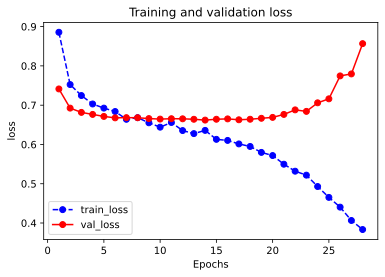

In [132]:
plot_metric(dfhistory,"loss")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3sbs8ryajj20h20a1gly.jpg)

In [ ]:
plot_metric(dfhistory,"auc")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h3sbsf8b1wj20f30a70t3.jpg)

In [134]:
model.evaluate(dl_val)

100%|██████████| 10/10 [00:00<00:00, 32.40it/s, val_auc=0.639, val_loss=0.684]


{'val_loss': 0.6842133283615113, 'val_auc': 0.6392135620117188}

{'val_loss': 0.6842133283615113, 'val_auc': 0.6392135620117188}

### 4，使用模型

In [135]:
labels = torch.tensor([x["label"] for x in ds_val])
preds = model.predict(dl_val)
val_auc = roc_auc_score(labels.cpu().numpy(),preds.cpu().numpy())
print(val_auc)

0.6392135469811272


0.6392135469811272

### 5, 保存模型

In [136]:
torch.save(model.net.state_dict(),"best_din.pt")
net_clone = create_net()
net_clone.load_state_dict(torch.load("best_din.pt"))

<All keys matched successfully>

In [137]:
net_clone.eval()
labels = torch.tensor([x["label"] for x in ds_val])
preds = torch.cat([net_clone(x).data for x in dl_val]) 
val_auc = roc_auc_score(labels.cpu().numpy(),preds.cpu().numpy())
print(val_auc)

0.6392135469811272


0.6392135469811272